# Plug and play prior

https://engineering.purdue.edu/~bouman/Plug-and-Play/webdocs/GlobalSIP2013a.pdf

Use bm3d: https://pypi.org/project/bm3d/

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops
import pyproximal
import bm3d
import segyio

from scipy.signal import filtfilt
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.pnp import PlugAndPlay

np.random.seed(0)

In [2]:
def snr(x, xest):
    return 20 * np.log( np.linalg.norm(x) / np.linalg.norm(x-xest))

def callback(x, xtrue, xhist, errhist):
    xhist.append(x)
    errhist.append(np.linalg.norm(x - xtrue))

## MRI

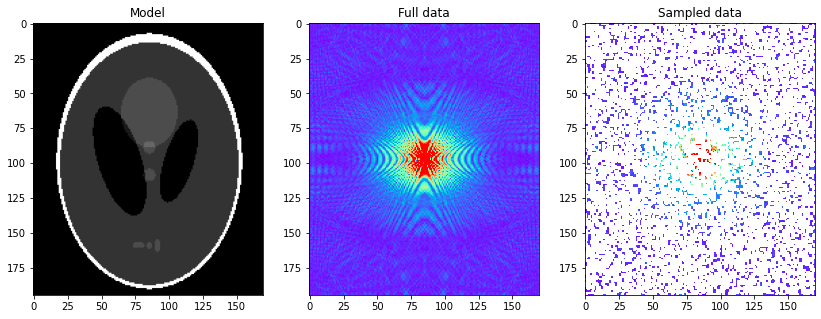

In [3]:
x = np.load("../data/optimization/shepp_logan_phantom.npy")
x = x / x.max()
ny, nx = x.shape

perc_subsampling = 0.6
nxsub = int(np.round(ny * nx * perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny * nx))[:nxsub])
Rop = pylops.Restriction(ny * nx, iava, dtype=np.complex128)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.0, (ny, nx))
y = Rop * Fop * (x.ravel() + n.ravel())
yfft = Fop * (x.ravel() + n.ravel())
yfft = np.fft.fftshift(yfft.reshape(ny, nx))

ymask = Rop.mask(Fop * (x.ravel()) + n.ravel())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("Full data")
axs[1].axis("tight")
axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[2].set_title("Sampled data")
axs[2].axis("tight");

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.250000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   2.56899e-03   7.005e+02   4.722e+00   7.052e+02
     2   6.20136e-03   5.594e+02   6.507e+00   5.659e+02
     3   1.01069e-02   4.459e+02   8.651e+00   4.545e+02
     4   1.30629e-02   3.553e+02   1.075e+01   3.661e+02
     5   1.58316e-02   2.835e+02   1.261e+01   2.961e+02
     6   1.83997e-02   2.265e+02   1.422e+01   2.407e+02
     7   2.07756e-02   1.812e+02   1.562e+01   1.969e+02
     8   2.29780e-02   1.453e+02   1.683e+01   1.621e+02
     9   2.50243e-02   1.167e+02   1.787e+01   1.346e+02
    10   2.69299e-02   9.398e+01   1.876e+01   1.127e+02
    11   2.87081e-02   7.589e+01   1.952e+01   9.541e+01
    21 

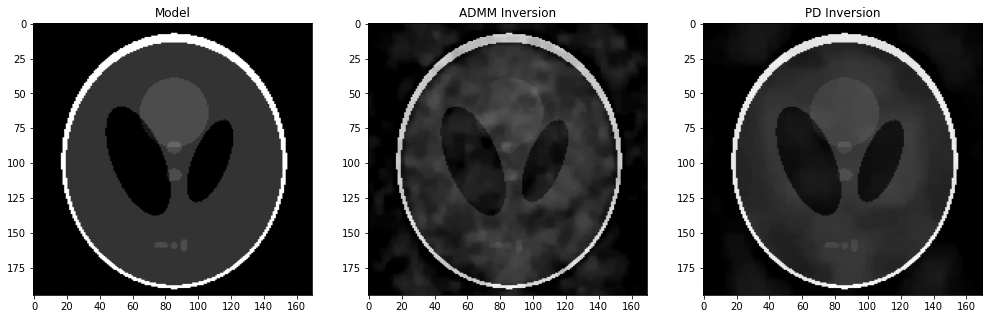

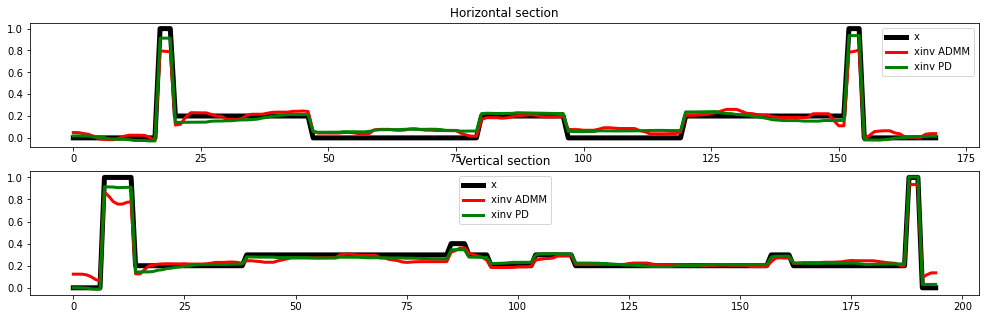

In [4]:
l2 = L2(Op=Rop * Fop, b=y.ravel(), niter=50, warm=True)
Gop = Gradient(dims=x.shape, edge=True, kind='forward', dtype=np.complex)

# Anisotropic TV
sigma = 1e-2
l1 = L1(sigma=sigma)

# Isotropic
#sigma = 1e-2
#l1 = L21(ndim=2, sigma=sigma)

L = 8 #np.real((Gop.H*Gop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = tau / L
xladmm = LinearizedADMM(l2, l1, Gop, tau=tau, mu=mu, x0=np.zeros(x.size, dtype=np.complex), 
                        niter=100, show=True)[0]
xladmm = np.real(xladmm.reshape(x.shape))

tau = .99 / np.sqrt(L)
mu = .99 / np.sqrt(L)
xpd = PrimalDual(l2, l1, Gop, x0=np.zeros(x.size, dtype=np.complex), tau=tau, mu=mu, theta=1., niter=100, show=True)
xpd = np.real(xpd.reshape(x.shape))


fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xladmm, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight")
axs[2].imshow(xpd, vmin=0, vmax=1, cmap="gray")
axs[2].set_title("PD Inversion")
axs[2].axis("tight")


fig, axs = plt.subplots(2, 1, figsize=(17, 5))
axs[0].plot(x[ny // 2], "k", lw=5, label="x")
axs[0].plot(xladmm[ny // 2], "r", lw=3, label="xinv ADMM")
axs[0].plot(xpd[ny // 2], "g", lw=3, label="xinv PD")

axs[0].set_title("Horizontal section")
axs[0].legend()
axs[1].plot(x[:, nx // 2], "k", lw=5, label="x")
axs[1].plot(xladmm[:, nx // 2], "r", lw=3, label="xinv ADMM")
axs[1].plot(xpd[:, nx // 2], "g", lw=3, label="xinv PD")
axs[1].set_title("Vertical section")
axs[1].legend();

Let's try now the PNP with BM3D

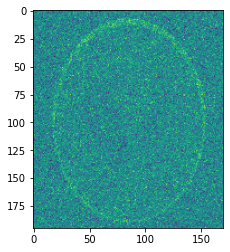

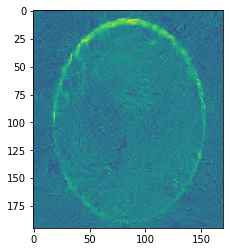

In [5]:
xn = x + np.random.normal(0,1,x.shape)
denoised_image = bm3d.bm3d(xn, sigma_psd=.8, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

plt.figure()
plt.imshow(xn)

plt.figure()
plt.imshow(denoised_image);

In [6]:
import bm3d
from pyproximal.ProxOperator import _check_tau
from pyproximal import ProxOperator
from pyproximal.projection import BoxProj

class BM3D(ProxOperator):
    r"""BM3D

    """
    def __init__(self, dims, sigma=1.):
        super().__init__(None, False)
        self.dims = dims
        self.sigma = sigma
    
    def __call__(self, x):
        return 0.
    
    @_check_tau
    def prox(self, x, tau):
        x = x.reshape(self.dims)
        xden = bm3d.bm3d(x, sigma_psd=self.sigma*tau, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
        return xden.ravel()

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class '__main__.BM3D'>
tau = 1.000000e+00	niter = 40

   Itn       x[0]          f           g       J = f + g
     1   1.15604e-02   2.216e+02   0.000e+00   2.216e+02
     2  -7.03531e-03   1.146e+02   0.000e+00   1.146e+02
     3  -1.39938e-02   5.296e+01   0.000e+00   5.296e+01
     4  -2.78265e-02   2.380e+01   0.000e+00   2.380e+01
     5  -2.24099e-02   1.124e+01   0.000e+00   1.124e+01
     6  -1.89930e-02   6.033e+00   0.000e+00   6.033e+00
     7  -1.92525e-02   3.882e+00   0.000e+00   3.882e+00
     8  -2.23982e-02   2.922e+00   0.000e+00   2.922e+00
     9  -2.32900e-02   2.447e+00   0.000e+00   2.447e+00
    10  -2.34597e-02   2.183e+00   0.000e+00   2.183e+00
    13  -2.16795e-02   1.841e+00   0.000e+00   1.841e+00
    17  -1.67930e-02   1.626e+00   0.000e+00   1.626e+00
    21  -1.18697e-02   1.520e+00   0.000e+00   1.520e+00
  

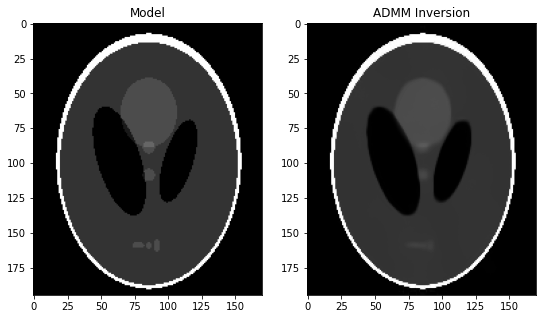

In [7]:
l2 = L2(Op=Rop * Fop, b=y.ravel(), niter=50, warm=True)

# BM3D
sigma = .05
lpnp = BM3D(dims=x.shape, sigma=sigma)

L = 1.
tau = 1./L
xpnp = ADMM(l2, lpnp, tau=tau, x0=np.zeros(x.size), 
            niter=40, show=True)[0]
xpnp = np.real(xpnp.reshape(x.shape))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnp, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight");

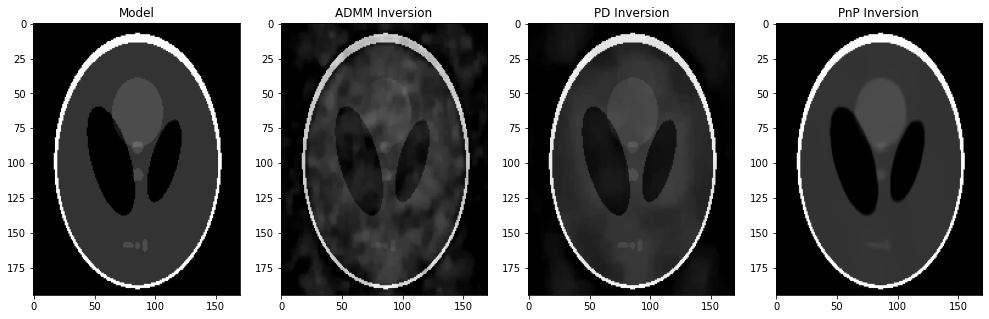

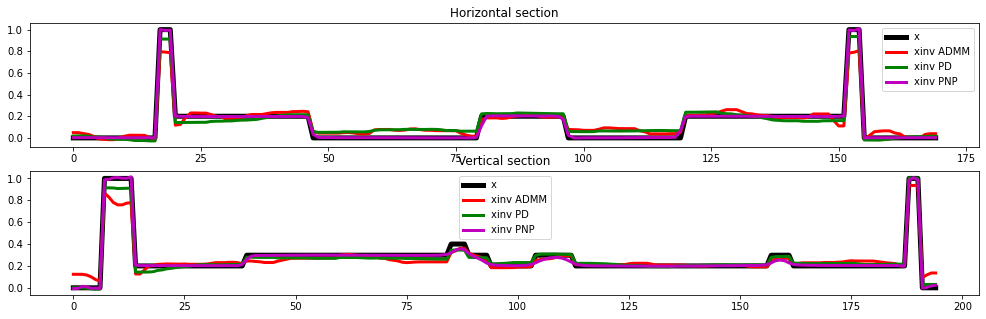

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(17, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xladmm, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight")
axs[2].imshow(xpd, vmin=0, vmax=1, cmap="gray")
axs[2].set_title("PD Inversion")
axs[2].axis("tight")
axs[3].imshow(xpnp, vmin=0, vmax=1, cmap="gray")
axs[3].set_title("PnP Inversion")
axs[3].axis("tight")

fig, axs = plt.subplots(2, 1, figsize=(17, 5))
axs[0].plot(x[ny // 2], "k", lw=5, label="x")
axs[0].plot(xladmm[ny // 2], "r", lw=3, label="xinv ADMM")
axs[0].plot(xpd[ny // 2], "g", lw=3, label="xinv PD")
axs[0].plot(xpnp[ny // 2], "m", lw=3, label="xinv PNP")
axs[0].set_title("Horizontal section")
axs[0].legend()
axs[1].plot(x[:, nx // 2], "k", lw=5, label="x")
axs[1].plot(xladmm[:, nx // 2], "r", lw=3, label="xinv ADMM")
axs[1].plot(xpd[:, nx // 2], "g", lw=3, label="xinv PD")
axs[1].plot(xpnp[:, nx // 2], "m", lw=3, label="xinv PNP")
axs[1].set_title("Vertical section")
axs[1].legend();

In [9]:
print(snr(x,xladmm), snr(x,xpd), snr(x,xpnp))

24.678585650154098 35.30853833991115 61.782377348460145


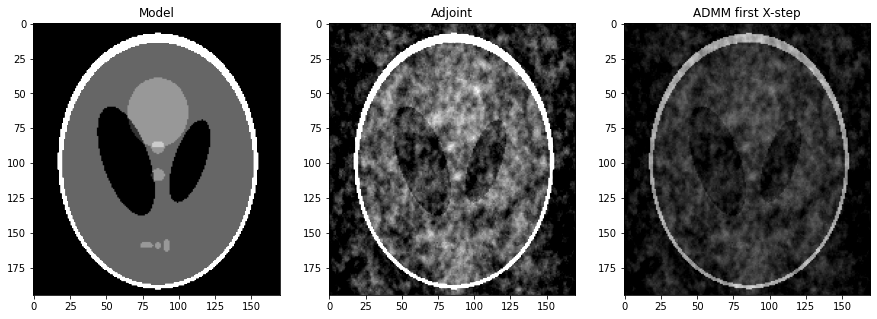

In [10]:
# First step prior to the denoise
Op = Rop * Fop
l2 = L2(Op=Op, b=y.ravel(), niter=50, warm=True)

xadj = np.real(Op.H * y.ravel()).reshape(x.shape)
x1 = np.real(l2.prox(np.zeros_like(x).ravel(), tau).reshape(x.shape))


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x, vmin=0, vmax=0.5, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xadj, vmin=0, vmax=0.5, cmap="gray")
axs[1].set_title("Adjoint")
axs[1].axis("tight");
axs[2].imshow(x1, vmin=0, vmax=0.5, cmap="gray")
axs[2].set_title("ADMM first X-step")
axs[2].axis("tight");

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.000000e+00	niter = 40

   Itn       x[0]          f           g       J = f + g
     1   1.15604e-02   2.216e+02   0.000e+00   2.216e+02
     2  -7.03531e-03   1.146e+02   0.000e+00   1.146e+02
     3  -1.39938e-02   5.296e+01   0.000e+00   5.296e+01
     4  -2.78265e-02   2.380e+01   0.000e+00   2.380e+01
     5  -2.24099e-02   1.124e+01   0.000e+00   1.124e+01
     6  -1.89930e-02   6.033e+00   0.000e+00   6.033e+00
     7  -1.92525e-02   3.882e+00   0.000e+00   3.882e+00
     8  -2.23982e-02   2.922e+00   0.000e+00   2.922e+00
     9  -2.32900e-02   2.447e+00   0.000e+00   2.447e+00
    10  -2.34597e-02   2.183e+00   0.000e+00   2.183e+00
    13  -2.16795e-02   1.841e+00   0.000e+00   1.841e+00
    17  -1.67930e-02   1.626e+00   0.000e+00   1.626e+00
    21  -1.18697e-02   1.520e+00   0

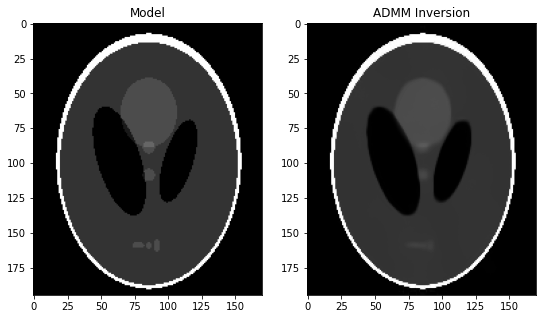

In [11]:
Op = Rop * Fop
l2 = L2(Op=Op, b=y.ravel(), niter=50, warm=True)

# BM3D
sigma = 0.05
denoiser = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma*tau, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

L = np.real((Op.H*Op).eigs(neigs=1, which='LM')[0])
tau = 1./L
xhist, errhist = [], []
xpnp = PlugAndPlay(l2, denoiser, x.shape, tau=tau, x0=np.zeros(x.size), 
                   niter=40, gfirst=False,
                   show=True, callback=lambda xx: callback(xx, x.ravel(), xhist, errhist))[0]
xpnp = np.real(xpnp.reshape(x.shape))

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnp, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("ADMM Inversion")
axs[1].axis("tight");

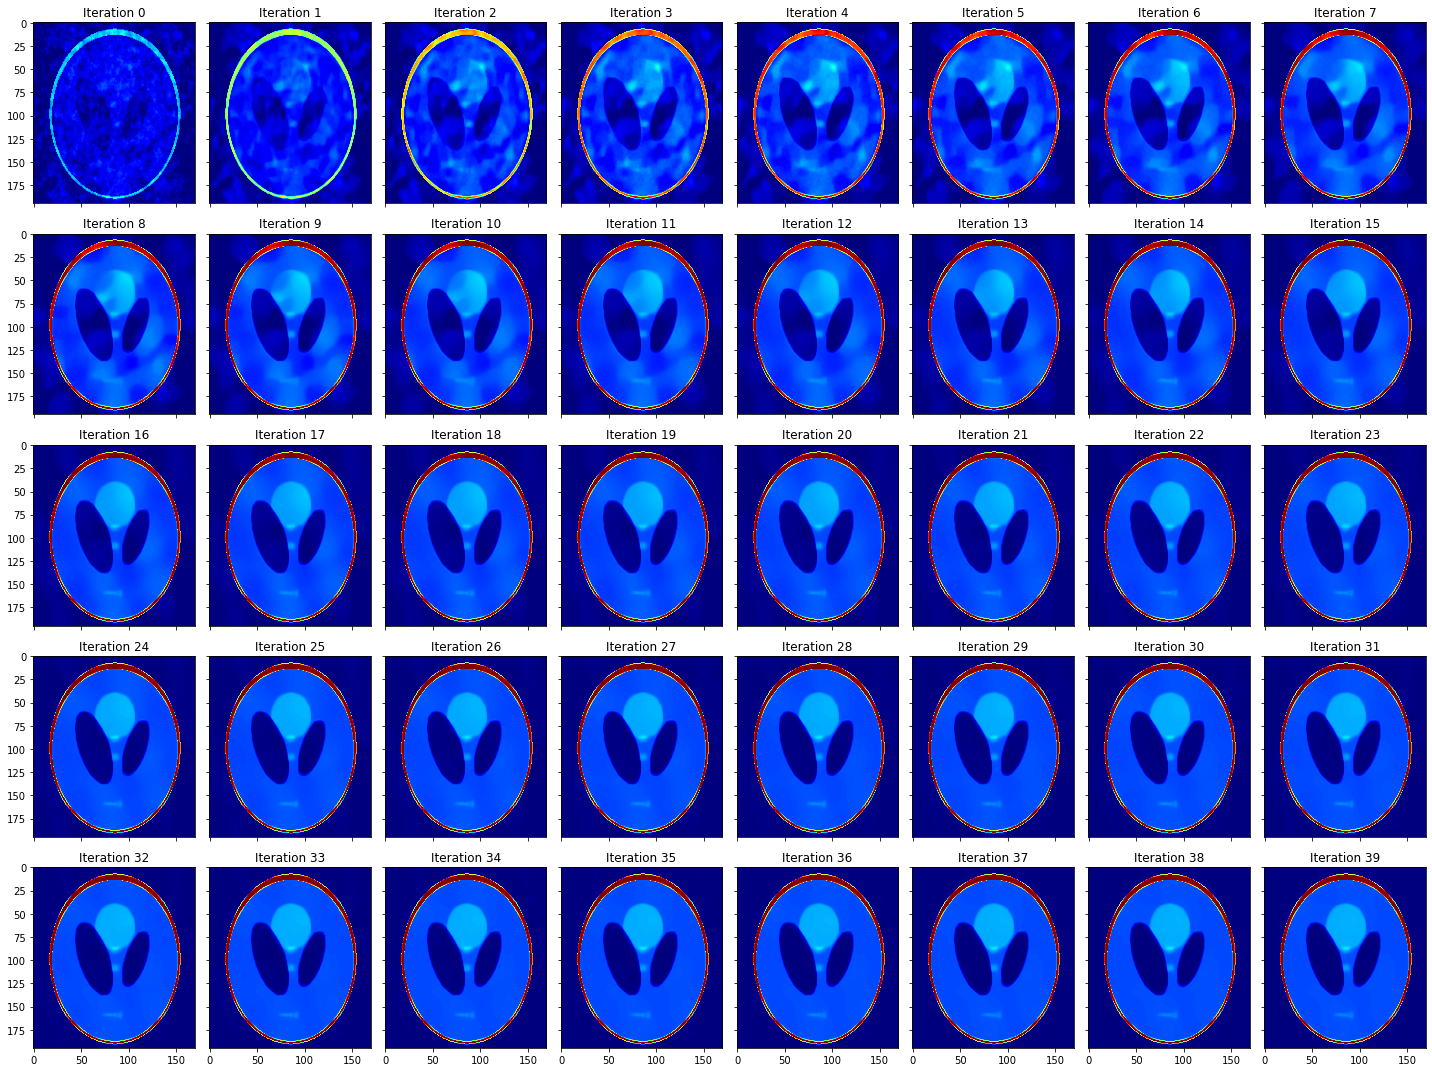

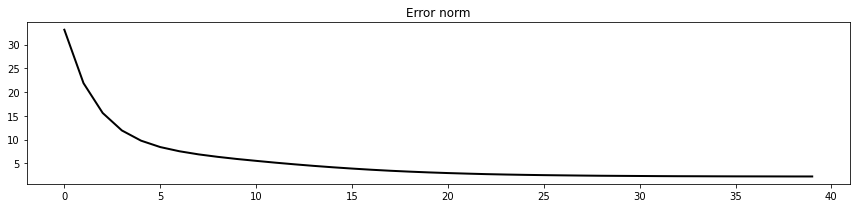

In [12]:
fig, axs = plt.subplots(5, 8, sharex=True, sharey=True, figsize=(20, 15))
axs = axs.ravel()

for i in range(40):
    axs[i].imshow(np.real(xhist[i]).reshape(x.shape), vmin=0, vmax=1, cmap="jet")
    axs[i].set_title('Iteration %d' %i)
    axs[i].axis('tight')
fig.tight_layout()
    
plt.figure(figsize=(12, 3))
plt.plot(errhist, 'k', lw=2)
plt.title("Error norm")
plt.tight_layout()

In [13]:
print(snr(x,xladmm), snr(x,xpd), snr(x,xpnp))

24.678585650154098 35.30853833991115 61.782377348460145


## Post-stack inversion

In [14]:
f = segyio.open('../data/seismicinversion/timodel_vp.segy', ignore_geometry=True)
v = segyio.collect(f.trace[:]).T
v = np.pad(v, ((80, 0), (0, 0)), constant_values=v[0, 0])
v = v[::8, ::8]

nt0, nx = v.shape
dt0 = 0.008
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

rho = 2000.
m = np.log(v*rho)

In [15]:
# smooth model
nsmooth = 30
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1,
                 filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0), axis=1)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()

# colored noise
sigman = 1e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nt0, nx)).T, method='gust').T,
             method='gust').ravel()
dn = d + n

# background data
dback = Lop * mback.ravel()

d = d.reshape(nt0, nx)
dn = dn.reshape(nt0, nx)
dback = dback.reshape(nt0, nx)

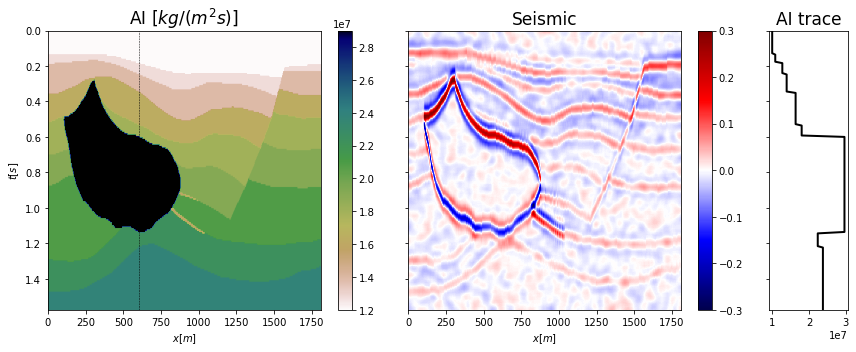

In [16]:
cmap='gist_earth_r'

fig, axs = plt.subplots(1, 3, sharey=True, 
                        gridspec_kw={'width_ratios': [3, 3, 0.7]}, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
plt.colorbar(im, ax=axs[0])
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(dn, cmap='seismic', vmin=-0.3, vmax=0.3, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title('Seismic', fontsize=17)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
axs[2].plot(np.exp(m[:, nx//3]), t0, 'k', lw=2)
axs[2].axis('tight')
axs[2].set_title('AI trace', fontsize=17)
plt.tight_layout()

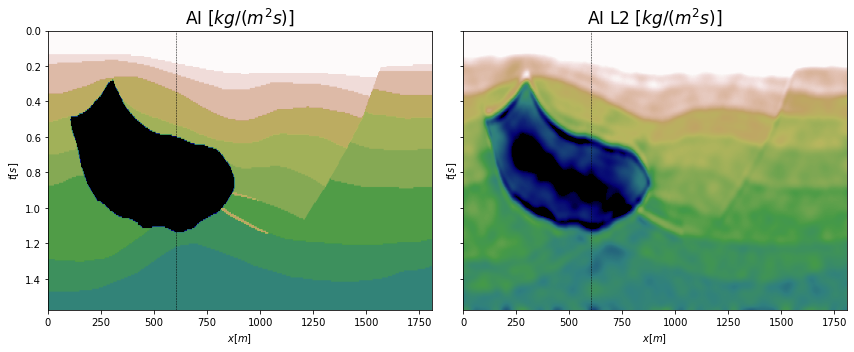

In [17]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[2.], returninfo=False, show=False,
                            **dict(iter_lim=100, damp=1e-4))
dinv = Lop*minv

minv = minv.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(minv), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI L2 $[kg/(m^2s)]$', fontsize=17)
plt.tight_layout()

1st step of L-ADMM

$$
prox_{\tau f}(\mathbf{x}) =
        \left(\mathbf{I} + \tau \sigma \mathbf{Op}^T \mathbf{Op} \right)^{-1}
        \left( \mathbf{x} + \tau \sigma \mathbf{Op}^T \mathbf{b}\right)
$$

which is basically the first step of PnP with ADMM:

$$
\mathbf{x}^{1} = prox_{\mu f}(\mathbf{x}^{0} - \mu / \tau \mathbf{Op}^H (\mathbf{Op}\mathbf{u}^{0} - \mathbf{z}^{0}+\mathbf{u}^{0}))
$$

where $\mathbf{z}^{0}=\mathbf{u}^{0}=0$. As we will see this $\mathbf{x}^{0}$ seems to be fundamental to get a meaningful inversion without choosing $\mu$ very large...

1.0 0.12375


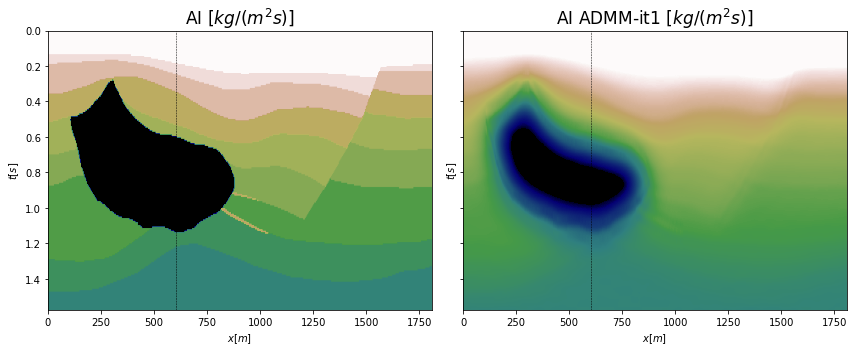

In [18]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

sigma=0.04
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=10, warm=True)

# steps
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)
print(tau, mu)

m1 = l2.prox(mback.ravel(), mu)
m1 = m1.reshape(m.shape)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(m1), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI ADMM-it1 $[kg/(m^2s)]$', fontsize=17)
plt.tight_layout()

1.0 0.12375
Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
tau = 1.000000e+00	mu = 1.237500e-01	niter = 80

   Itn       x[0]          f           g       J = f + g
     1   1.61169e+01   5.126e+01   2.121e+01   7.247e+01
     2   1.61170e+01   4.126e+01   2.190e+01   6.316e+01
     3   1.61182e+01   3.423e+01   2.272e+01   5.695e+01
     4   1.61204e+01   2.901e+01   2.352e+01   5.253e+01
     5   1.61234e+01   2.503e+01   2.424e+01   4.927e+01
     6   1.61267e+01   2.199e+01   2.483e+01   4.682e+01
     7   1.61298e+01   1.964e+01   2.531e+01   4.495e+01
     8   1.61325e+01   1.779e+01   2.572e+01   4.351e+01
     9   1.61346e+01   1.629e+01   2.603e+01   4.233e+01
    10   1.61364e+01   1.507e+01   2.625e+01   4.132e+01
    17   1.61502e+01   1.034e+01   2.677e+01   3.71

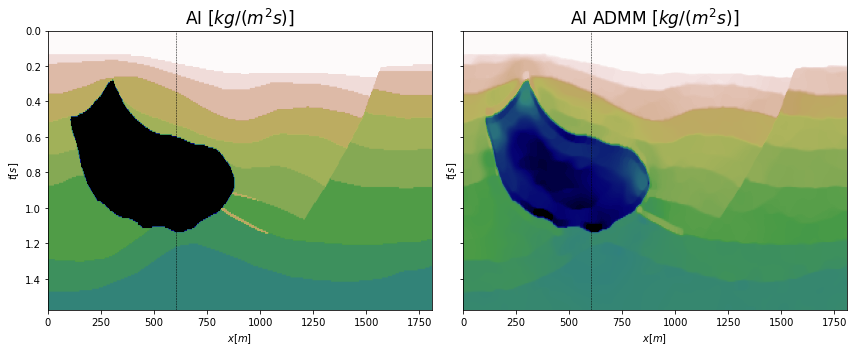

In [19]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

sigma=0.04
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=10, warm=True)

# steps
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)
print(tau, mu)

mladmmhist, errhist = [], []
mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=80, show=True,
                        callback=lambda x: callback(x, m.ravel(), mladmmhist, errhist))[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(mladmm), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI ADMM $[kg/(m^2s)]$', fontsize=17)
plt.tight_layout()

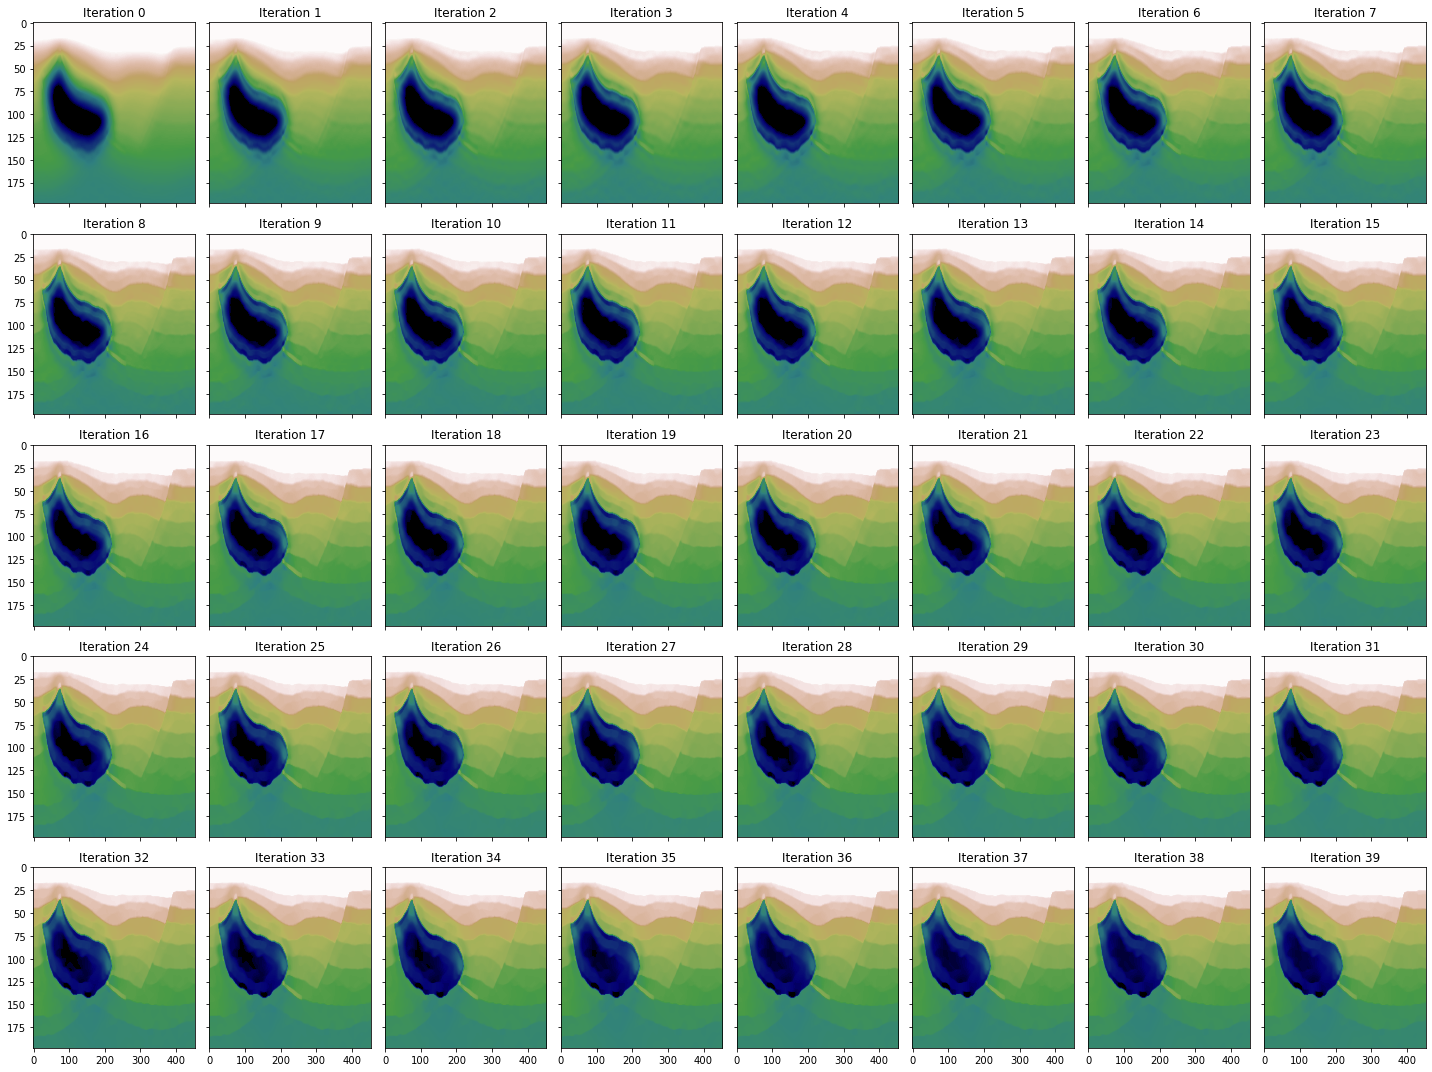

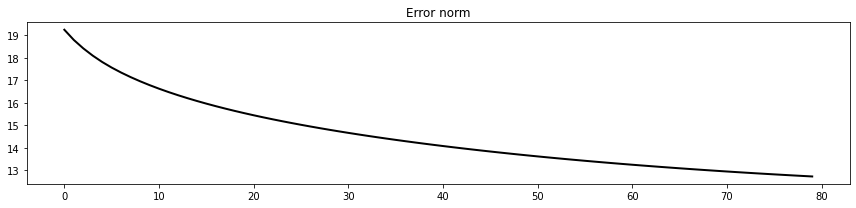

In [20]:
fig, axs = plt.subplots(5, 8, sharex=True, sharey=True, figsize=(20, 15))
axs = axs.ravel()

for i in range(40):
    axs[i].imshow(np.exp(mladmmhist[2*i].reshape(m.shape)), vmin=1.2e7, vmax=2.9e7, cmap=cmap)
    axs[i].set_title('Iteration %d' %i)
    axs[i].axis('tight')
fig.tight_layout()
    
plt.figure(figsize=(12, 3))
plt.plot(errhist, 'k', lw=2)
plt.title("Error norm")
plt.tight_layout()

Now we move to PnP with ADMM. Again let's first just solve the first iteration:

$$
prox_{\tau f}(\mathbf{x}=0) =
        \left(\mathbf{I} + \tau \sigma \mathbf{Op}^T \mathbf{Op} \right)^{-1}
        \left( \mathbf{x} + \tau \sigma \mathbf{Op}^T \mathbf{b}\right)
        =
        \left(\mathbf{I} + \tau \sigma \mathbf{Op}^T \mathbf{Op} \right)^{-1}
        \left(\tau \sigma \mathbf{Op}^T \mathbf{b}\right)
$$

which is basically the first step of PnP with ADMM:

$$
\mathbf{x}^{1} = prox_{\tau f}(\mathbf{z}^{0} - \mathbf{u}^{0})\\
\mathbf{z}^{1} = prox_{\tau g}(\mathbf{x}^{1} + \mathbf{u}^{0})\\
\mathbf{u}^{1} = \mathbf{u}^{0} + \mathbf{x}^{1} - \mathbf{z}^{1}
$$

where $\mathbf{z}^{0}=\mathbf{u}^{0}=0$

In [21]:
np.real((Lop.H*Lop).eigs(neigs=1, which='LM')[0])

1.9382285835446307

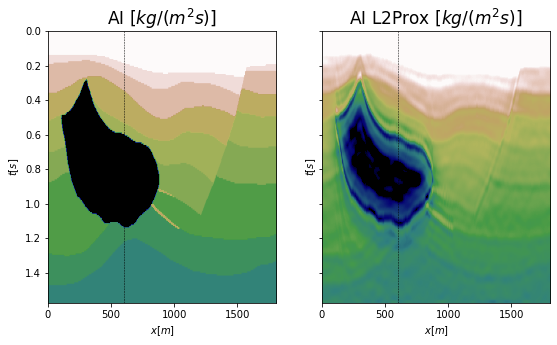

In [31]:
tau = 100.
m1 = lsqr(tau * Lop.H @ Lop + Identity(m.ravel().size), tau * Lop.H @ dn.ravel(), 
          x0=mback.ravel(), iter_lim=5)[0]
m1 = m1.reshape(m.shape)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(m1), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI L2Prox $[kg/(m^2s)]$', fontsize=17);

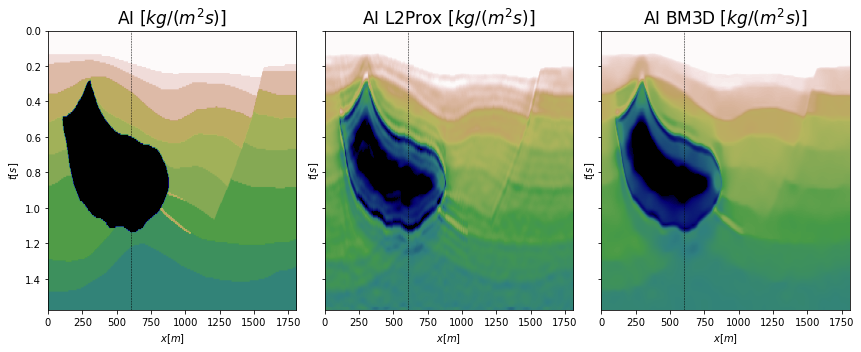

In [33]:
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=10, warm=True)
mpnp = l2.prox(np.zeros_like(m).ravel(), 1000.) # I need this big to get something meaningful
mpnp = mpnp.reshape(m.shape)

# BM3D
sigma = .1
denoiser = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

mpnp_den = denoiser(mpnp, 1.)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(mpnp), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI L2Prox $[kg/(m^2s)]$', fontsize=17)
im = axs[2].imshow(np.exp(mpnp_den), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
axs[2].set_ylabel(r'$t [s]$')
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title(r'AI BM3D $[kg/(m^2s)]$', fontsize=17)
plt.tight_layout()

0.1
ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.000000e+00	niter = 80

   Itn       x[0]          f           g       J = f + g
     1   1.61236e+01   4.881e+03   0.000e+00   4.881e+03
     2   1.61463e+01   3.203e+03   0.000e+00   3.203e+03
     3   1.61488e+01   2.715e+03   0.000e+00   2.715e+03
     4   1.61537e+01   2.483e+03   0.000e+00   2.483e+03
     5   1.61538e+01   2.314e+03   0.000e+00   2.314e+03
     6   1.61565e+01   2.204e+03   0.000e+00   2.204e+03
     7   1.61567e+01   2.112e+03   0.000e+00   2.112e+03
     8   1.61586e+01   2.046e+03   0.000e+00   2.046e+03
     9   1.61590e+01   1.986e+03   0.000e+00   1.986e+03
    10   1.61605e+01   1.942e+03   0.000e+00   1.942e+03
    17   1.61642e+01   1.741e+03   0.000e+00   1.741e+03
    25   1.61657e+01   1.622e+03   0.000e+00   1.622e+03
    33   1.61655e+01   1.544e+03

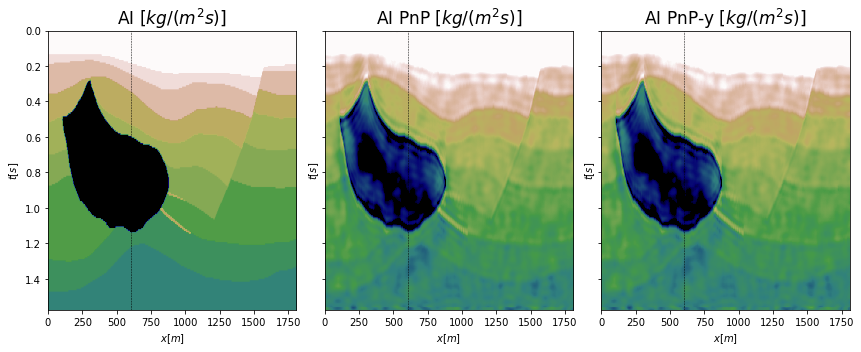

In [39]:
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=10, warm=True, sigma=1000.)

# BM3D
sigma = 1e-1
denoiser = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

xhist, errhist = [], []
mpnp, ypnp = PlugAndPlay(l2, denoiser, mback.shape, tau=1., x0=mback.ravel(), 
                         niter=80, gfirst=False, show=True, 
                         callback=lambda x: callback(x, m.ravel(), xhist, errhist))
mpnp = mpnp.reshape(m.shape)
ypnp = ypnp.reshape(m.shape)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(mpnp), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI PnP $[kg/(m^2s)]$', fontsize=17)
im = axs[2].imshow(np.exp(ypnp), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
axs[2].set_ylabel(r'$t [s]$')
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title(r'AI PnP-y $[kg/(m^2s)]$', fontsize=17)
plt.tight_layout()

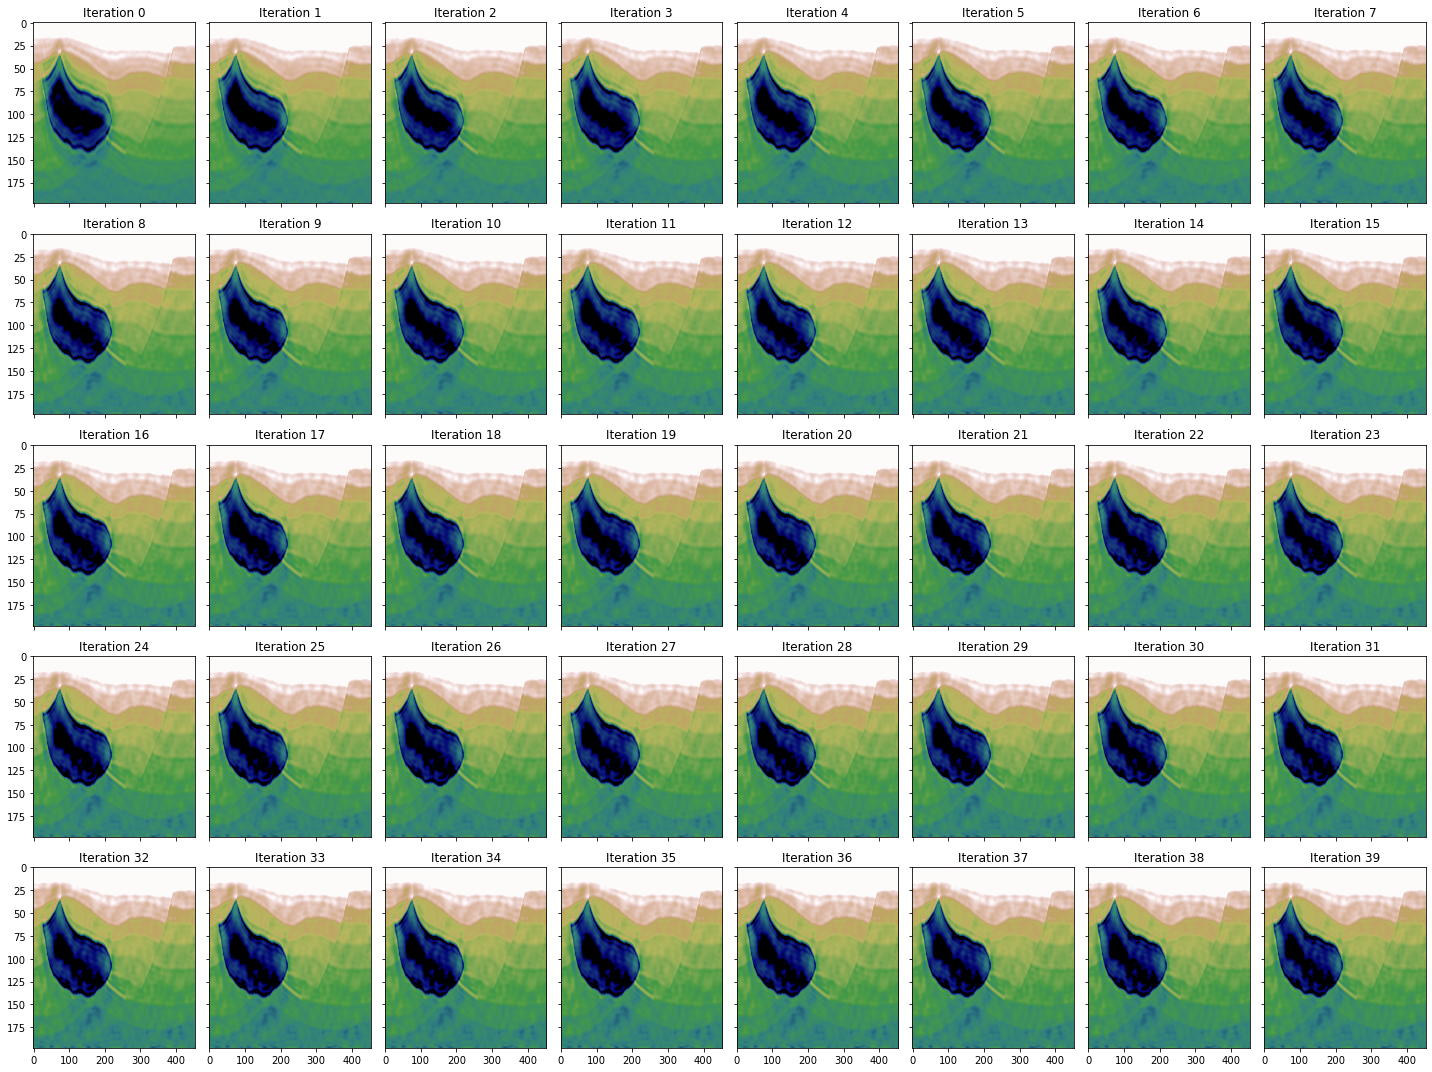

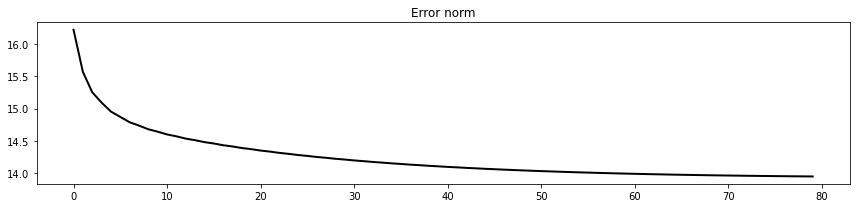

In [40]:
fig, axs = plt.subplots(5, 8, sharex=True, sharey=True, figsize=(20, 15))
axs = axs.ravel()

for i in range(40):
    axs[i].imshow(np.exp(xhist[2*i].reshape(m.shape)), vmin=1.2e7, vmax=2.9e7, cmap=cmap)
    axs[i].set_title('Iteration %d' %i)
    axs[i].axis('tight')
fig.tight_layout()
    
plt.figure(figsize=(12, 3))
plt.plot(errhist, 'k', lw=2)
plt.title("Error norm")
plt.tight_layout()

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.000000e+00	niter = 20

   Itn       x[0]          f           g       J = f + g
     1   1.61239e+01   4.881e+03   0.000e+00   4.881e+03
     2   1.61465e+01   3.204e+03   0.000e+00   3.204e+03
     3   1.61489e+01   2.715e+03   0.000e+00   2.715e+03
     4   1.61539e+01   2.483e+03   0.000e+00   2.483e+03
     5   1.61538e+01   2.314e+03   0.000e+00   2.314e+03
     6   1.61567e+01   2.205e+03   0.000e+00   2.205e+03
     7   1.61568e+01   2.112e+03   0.000e+00   2.112e+03
     8   1.61589e+01   2.046e+03   0.000e+00   2.046e+03
     9   1.61592e+01   1.987e+03   0.000e+00   1.987e+03
    10   1.61607e+01   1.942e+03   0.000e+00   1.942e+03
    11   1.61610e+01   1.900e+03   0.000e+00   1.900e+03
    12   1.61621e+01   1.867e+03   0.000e+00   1.867e+03
    13   1.61625e+01   1.835e+03   0

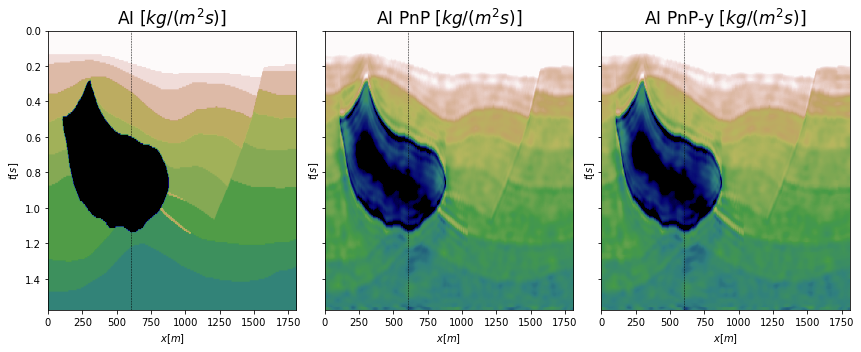

In [41]:
# let's try flipping the proxf and proxg updates in ADMM 
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=10, warm=True, sigma=1000.)

# BM3D
sigma = 1e-1
denoiser = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

xhist, errhist = [], []
mpnp, ypnp = PlugAndPlay(l2, denoiser, mback.shape, tau=1., x0=mback.ravel(), 
                         niter=20, gfirst=True, show=True, 
                         callback=lambda x: callback(x, m.ravel(), xhist, errhist))
mpnp = mpnp.reshape(m.shape)
ypnp = ypnp.reshape(m.shape)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(mpnp), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI PnP $[kg/(m^2s)]$', fontsize=17)
im = axs[2].imshow(np.exp(ypnp), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
axs[2].set_ylabel(r'$t [s]$')
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title(r'AI PnP-y $[kg/(m^2s)]$', fontsize=17)
plt.tight_layout()

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.000000e+00	niter = 40

   Itn       x[0]          f           g       J = f + g
     1   2.07355e-01   5.783e+02   0.000e+00   5.783e+02
     2   1.06265e-01   5.112e+01   0.000e+00   5.112e+01
     3   9.00880e-02   2.554e+01   0.000e+00   2.554e+01
     4   8.20856e-02   2.405e+01   0.000e+00   2.405e+01
     5   7.80540e-02   2.352e+01   0.000e+00   2.352e+01
     6   6.44725e-02   2.292e+01   0.000e+00   2.292e+01
     7   5.57453e-02   2.235e+01   0.000e+00   2.235e+01
     8   4.46091e-02   2.198e+01   0.000e+00   2.198e+01
     9   3.71125e-02   2.160e+01   0.000e+00   2.160e+01
    10   3.65058e-02   2.140e+01   0.000e+00   2.140e+01
    13   2.51855e-02   2.087e+01   0.000e+00   2.087e+01
    17   1.89383e-02   2.046e+01   0.000e+00   2.046e+01
    21   5.94998e-03   2.019e+01   0

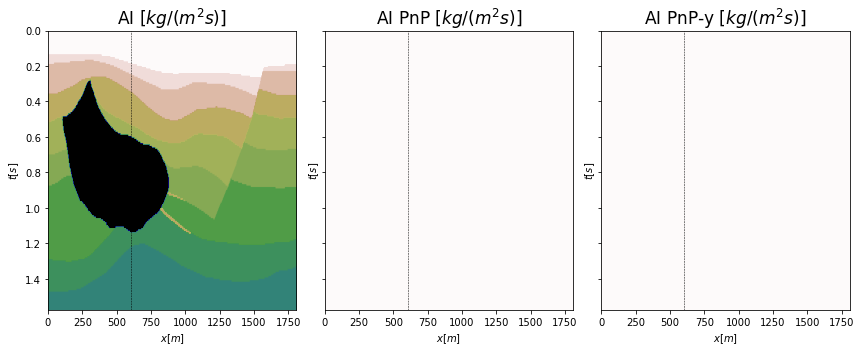

In [45]:
# What if instead we make tau smaller....
l2 = L2(Op=Lop, b=dn.ravel(), x0=mback.ravel(), niter=10, warm=True, sigma=10)

# BM3D
sigma = 1e-1
denoiser = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

xhist, errhist = [], []
mpnp, ypnp = PlugAndPlay(l2, denoiser, mback.shape, tau=1., x0=mback.ravel(), 
                         niter=40, gfirst=False, show=True, 
                         callback=lambda x: callback(x, m.ravel(), xhist, errhist))
mpnp = mpnp.reshape(m.shape)
ypnp = ypnp.reshape(m.shape)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
im = axs[0].imshow(np.exp(m), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[0].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[0].axis('tight')
axs[0].set_ylabel(r'$t [s]$')
axs[0].set_xlabel(r'$x [m]$')
axs[0].set_title(r'AI $[kg/(m^2s)]$', fontsize=17)
im = axs[1].imshow(np.exp(mpnp), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[1].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[1].axis('tight')
axs[1].set_ylabel(r'$t [s]$')
axs[1].set_xlabel(r'$x [m]$')
axs[1].set_title(r'AI PnP $[kg/(m^2s)]$', fontsize=17)
im = axs[2].imshow(np.exp(ypnp), vmin=1.2e7, vmax=2.9e7,
                   cmap=cmap, extent=(x[0], x[-1], t0[-1], t0[0]))
axs[2].axvline(x[nx//3], c='k', ls='--', lw=0.5)
axs[2].axis('tight')
axs[2].set_ylabel(r'$t [s]$')
axs[2].set_xlabel(r'$x [m]$')
axs[2].set_title(r'AI PnP-y $[kg/(m^2s)]$', fontsize=17)
plt.tight_layout()

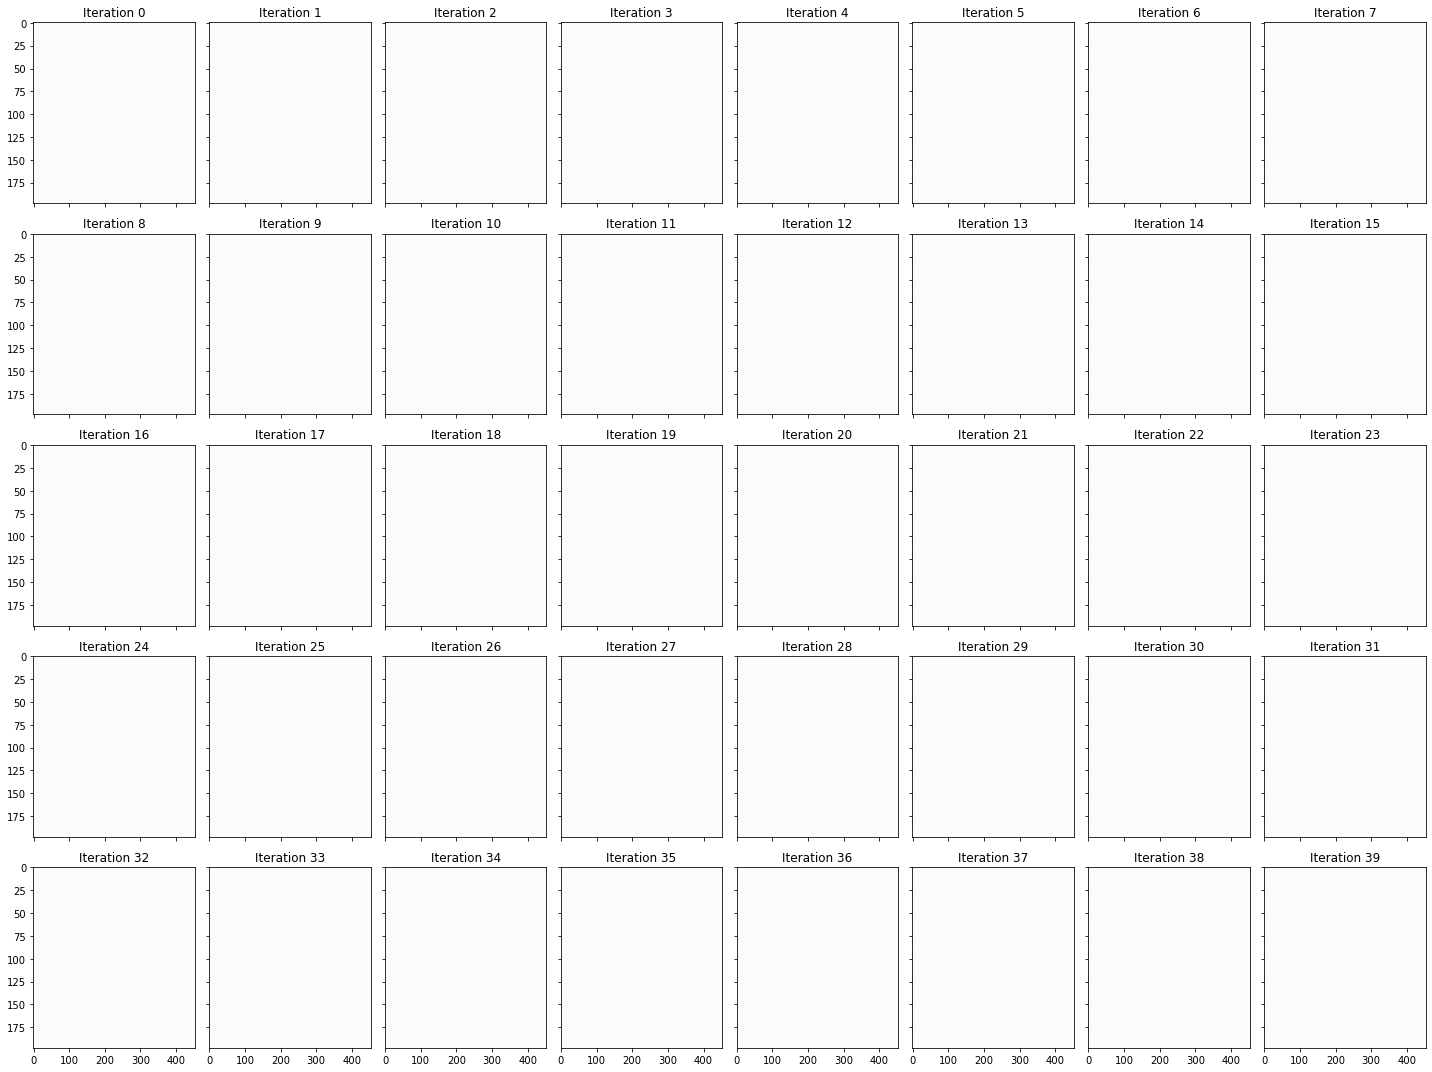

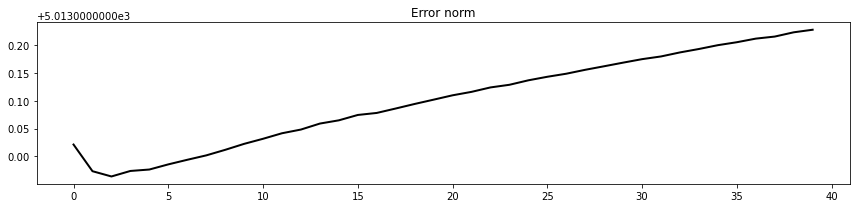

In [46]:
fig, axs = plt.subplots(5, 8, sharex=True, sharey=True, figsize=(20, 15))
axs = axs.ravel()

for i in range(40):
    axs[i].imshow(np.exp(xhist[i].reshape(m.shape)), vmin=1.2e7, vmax=2.9e7, cmap=cmap)
    axs[i].set_title('Iteration %d' %i)
    axs[i].axis('tight')
fig.tight_layout()
    
plt.figure(figsize=(12, 3))
plt.plot(errhist, 'k', lw=2)
plt.title("Error norm")
plt.tight_layout()